# Loading new data

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from modules import *
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import glob
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import cm

In [2]:
file = "H:\Github\Antarctica-M.2\data\land ice\GRCTellus.JPL.200204_202008.GLO.RL06M.MSCNv02CRI.nc"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 188)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-08-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-08-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...


In [3]:
data  = ds.lwe_thickness

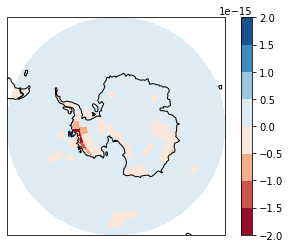

In [4]:
trend = data.polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1).sel(lat=slice(-90,-50))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
contour = ax.contourf(trend.lon, trend.lat, trend.values, transform=ccrs.PlateCarree(), cmap = 'RdBu')
plt.colorbar(contour)
ax.coastlines()
plt.show()

# Temperature

In [5]:
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1] and 't' in f.split('\\')[1]]
ds = xr.open_mfdataset(files, parallel=True)

ds = ds.compute()

In [6]:
ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
#       .pipe(w5.normalise_indepenant, dependant='sic')
     )
ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4128 -0.427 -0.4652
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4215 -0.4357 -0.4746
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875

In [7]:
area = xr.open_dataset('data/area_files/processed_nsidc.nc').area

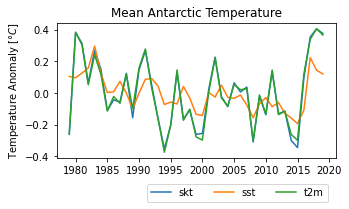

In [8]:
fig = plt.figure(figsize=(5,2.5))
for t in ds:
    data = (ds[t]*area).mean(dim=('x','y'))/area.mean(dim=('x','y'))
    plt.plot(data.time, data,label = t)
plt.legend(bbox_to_anchor=(0.99, -0.15), ncol = 3, loc = 'upper right')
plt.title('Mean Antarctic Temperature')
plt.ylabel('Temperature Anomaly [$\degree C$]')
plt.savefig('images/week6/TemperatureTimeseries.pdf', bbox_inches='tight')
plt.show()

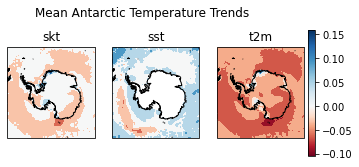

In [9]:
fig = plt.figure(figsize=(5,2.5))

gradient = xr.Dataset()
for t in ds:
    gradient[t] = ds[t].polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1)* 1e9*60*60*24*365

max_ = max([gradient[indexname].max() for indexname in gradient])
min_ = min([gradient[indexname].min() for indexname in gradient])
if max_>min_ and max_>0 and min_<0:
    divnorm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
else:
    sys.exit(f'min = {min_.values}, max = {max_.values}, {variables}')
i=0
for t in ds:
    ax = fig.add_subplot(1,3,i+1, projection = ccrs.SouthPolarStereo())
    data = gradient[t]
    contour = ax.contourf(data.x, data.y, data, cmap='RdBu')
    ax.set_title(t)
    ax.coastlines()
    i +=1
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=divnorm, cmap='RdBu'), cax=cbar_ax, shrink=0.88)
plt.suptitle('Mean Antarctic Temperature Trends')
plt.savefig('images/week6/Temperature_Trends.pdf', bbox_inches='tight')
plt.show()